In [1]:
"""
This script implement wildfire simulation based on CA model using actual dataset from California.
The datasets were downloaded from Google Earth Engine. The datasets include slope, land use, Normalized Difference Value Index (NDVI),
Normalized Difference Drought Index (NDDI), surface temperature, proximity to road (meters), wind speed, wind direction, fire history (synthetic data), and 
lightening density (synthetic data)
"""

import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import folium
from rasterio.plot import reshape_as_image
from folium.raster_layers import ImageOverlay
from matplotlib.colors import ListedColormap
from branca.element import Template, MacroElement
from matplotlib import cm
from matplotlib.colors import Normalize
from random import shuffle
import requests
import pandas as pd
from datetime import datetime, timedelta
from itertools import product
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [2]:
# Reading the necessary files.
# path = '/Users/nancyadomako-appiah/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/CSE6730/ClassProject' 

path = '../experiments/dataset'

In [3]:
# Fuel Factors based flammability of the specific land use and Alexandridis et al., 2008
fuel_to_factor = {
    4: -0.3,   # Agriculture
    2: 0.0,    # Thickets (Shrub/Grassland)
    1: 0.4,    # Trees (Forest)
    7: -0.4,   # Bare soil (minimal to no fuel)
    6: -0.6,   # Built area (generally non-flammable or fire breaks)
    3: -0.2,   # Flooded vegetation (reduced burn potential)
    5: 0.0,    # Shrub/Grassland
    8: -0.8    # Snow/Ice (non-burnable)
}

In [4]:
EMPTY = 0       # No vegetation
VEGETATION = 1  # Vegetation present (fuel)
BURNING = 9     # Actively burning
BURNED = 10      # Completely burned

In [5]:
# Define Moore Neighborhood (8 neighbors)
NEIGHBORHOOD = [(-1, -1), (-1, 0), (-1, 1),
                (0, -1),          (0, 1),
                (1, -1),  (1, 0), (1, 1)]

# Fire Spread Constants & Environmental Parameters
P0 = 0.58   # Base probability of fire spread
C1 = 0.045  # Wind speed coefficient
C2 = 0.131  # Wind direction coefficient
A = 0.078   # Elevation coefficient

In [6]:
#Function to select the indices of pixels with the highest ignition probability
def top_n_indices_ignore_nan(array, n):
    flat = array.flatten()
    valid_mask = ~np.isnan(flat)

    if np.sum(valid_mask) < n:
        raise ValueError("Not enough valide (non-Nan) entries to select topN.")
    
    valid_values = flat[valid_mask]
    valid_indices = np.flatnonzero(valid_mask)

    top_n_valid_idx = np.argsort(valid_values)[-n:][::-1] #sorted descending

    top_n_flat_idx = valid_indices[top_n_valid_idx]

    return np.unravel_index(top_n_flat_idx, array.shape)

In [7]:
#Ignition Model Implemented on an actual dataset for slope, road approximity, drought index, and surface temperature
# lightening density and fire history (synthetic)

def generat_inputs(grid_size):
    rng = np.random.default_rng(seed=42)
   
    #Lightning: somewhat uniform, low density
    lightning_density = rng.exponential(scale=0.3, size=(grid_size[0], grid_size[1]))
    lightning_density = np.clip(lightning_density, 0, 1)
    
    #Fire history: sparse ignition zones
    fire_history = rng.choice([0,1], size=(grid_size[0], grid_size[1]))
    
    return lightning_density, fire_history


def compute_ignition_probability_map(
    ndvi, slope,lightning_density, road_proximity,
    land_use, fire_history, surtemp, nddi,
    land_use_weights = None
):
    norm = lambda x: (x-np.nanmin(x))/(np.nanmax(x) -np.nanmin(x)+1e-6)
    
    
    slope_norm = norm(slope)
    lightning_norm = norm(lightning_density)
    roads_norm = 1- norm(road_proximity) # closer to roads = higher ignition
    temp_norm = norm(surtemp)
    dryness_norm = norm(nddi)
    fire_hist_norm = norm(fire_history)
    ndvi_norm = norm(ndvi)
    
    land_weight_map = np.zeros_like(land_use, dtype=np.float32)
    
    if land_use_weights:
        for code, weight in land_use_weights.items():
            land_weight_map[land_use == code] = weight
    else:
        land_weight_map = np.ones_like(ndvi)
            
    beta = {
        'veg': 0.25,
        'slope':0.15,
        'lightning':0.2,
        'roads': 0.1,
        'land_use': 0.15,
        'fire_hist': 0.1,
        'temp':0.1,
        'dryness':0.2
    }
    
    z = (
        beta['veg']*ndvi_norm+
        beta['slope']*slope_norm +
        beta['lightning']*lightning_norm+
        beta['roads']*roads_norm+
        beta['land_use']*land_weight_map+
        beta['fire_hist']*fire_hist_norm+
        beta['temp']*temp_norm+
        beta['dryness']*dryness_norm
    )
    
    ignition_prob = 1/(1 + np.exp(-z))

    return ignition_prob

# Function to set the ignition
def ignite_fire(grid, ignition_prob, top_n = 1, mask = None):
    if mask is not None:
        ignition_prob = np.where(mask, ignition_prob, np.nan) #Mask out with Nans

    try:
        rows, cols = top_n_indices_ignore_nan(ignition_prob, top_n)
    except ValueError as e:
        print(f"Warning: {e}")
        return grid, []
    for x, y in zip(rows, cols):
        grid[x,y] = BURNING

    #return grid, list(zip(rows, cols))
    return grid

In [8]:
#Function to transform the rasters into the same shape
#before using in the model

def align_and_resample_raster(src_path, ref_path, out_path,
                              resampling_method=Resampling.nearest):
    with rasterio.open(ref_path) as ref:
        ref_crs = ref.crs
        ref_transform = ref.transform
        ref_width = ref.width
        ref_height = ref.height

        with rasterio.open(src_path) as src:
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs, ref_crs, src.width, src.height, *src.bounds, dst_width=ref_width, dst_height=ref_height)

            kwargs = src.meta.copy()
            kwargs.update({
                'crs': ref_crs,
                'transform': ref_transform,
                'width': ref_width,
                'height': ref_height
            })

            with rasterio.open(out_path, 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=resampling_method
                )


In [31]:
src_path = os.path.join(path, "proximity_road.tif")
ref_path = os.path.join(path,"landuse.tif")
out_path = os.path.join(path, "transforroad.tif")

align_and_resample_raster(src_path, ref_path, out_path)

In [40]:
src_path = os.path.join(path, "surftemp.tif")
ref_path = os.path.join(path,"landuse.tif")
out_path = os.path.join(path, "transfortemp.tif")

align_and_resample_raster(src_path, ref_path, out_path)

In [ ]:
src_path = os.path.join(path, "nddi.tif")
ref_path = os.path.join(path,"landuse.tif")
out_path = os.path.join(path, "transfornddi.tif")

align_and_resample_raster(src_path, ref_path, out_path)

In [9]:
#Testing ignition model

land_use_weights = {
    1: 0.9, #trees/forest
    2: 0.6, # thickets (shrub/Grassland)
    3: 0.0, # Flooded vegetation
    4: 0.5, # Agriculture crops
    5: 0.6, # Shrub/Grassland
    6: 0.2, # Built-area/urban area
    7: 0.1, #Bare soil
    8: 0.0 # snow/ice
}
with rasterio.open(os.path.join(path,"landuse.tif")) as landuse:
    land_use = landuse.read(1)
    
    with rasterio.open(os.path.join(path, "SlopeExport.tif")) as slopetif:
        slope_ = slopetif.read(1)
        
    with rasterio.open(os.path.join(path, "NDVI.tif")) as veg_ndvi:
        ndviveg = veg_ndvi.read(1)
            
    with rasterio.open(os.path.join(path, "transforroad.tif")) as proxiroad:
        roadprix = proxiroad.read(1)
                
    with rasterio.open(os.path.join(path, "transfortemp.tif")) as surftempnew:
        temp = surftempnew.read(1)
                    
    with rasterio.open(os.path.join(path, "transfornddi.tif")) as dryness:
        dryness_index = dryness.read(1)
        dryness_index = np.where((dryness_index < -1) | (dryness_index > 1), np.nan, dryness_index)
                        
    grid_size = land_use.shape
                        
    lightning_density, fire_history = generat_inputs(grid_size)
                        
    ignitionprob = compute_ignition_probability_map(
                            ndviveg, slope_,lightning_density, roadprix,
                            land_use, fire_history, temp, dryness_index,
                            land_use_weights)
                        
    newlanduse = np.where(np.isnan(land_use), -999, land_use)
        
    landusegrid = np.where(newlanduse == 0, EMPTY, newlanduse)
    ignition = ignite_fire(landusegrid, ignitionprob)

In [104]:
# Calculation of fire propagation probability

def calculate_fire_probability(p0, p_veg_factor, wind_speed, wind_dir, terrain_slope, fire_dir, p_den):

    if p_den <= 0.2:
        p_den = -0.4

    elif p_den <= 0.5:
        p_den = 0
        
    elif p_den > 0.5:
        p_den = 0.3

    theta = np.cos(np.deg2rad(abs(wind_dir - fire_dir)))
    P_w = np.exp(C1 * wind_speed) * np.exp(C2 * wind_speed * (theta - 1))
    P_ele = np.exp(A * terrain_slope)
    return min(p0 * (1 + p_veg_factor)*(1 + p_den) * P_w * P_ele, 1)

In [11]:
# Visulation function

def plot_grid(grid, step):
    colors = {
        0: ('Water', (0, 112, 192)),    # water // medium Blue
        1: ('Trees', (34, 139, 34)),     # tree/vegetation // Green
        2: ('Grass', (124, 252, 0)),  # grass // Bright Lime Green
        3: ('Flooded Vegetation',(0, 255, 255)), # Flooded Vegetation // Cyan
        4: ('Crops', (255, 255, 0)), # crop // Bright Yellow
        5: ('Shrub and Scrub', (160, 82, 45)), # Shrub and Scrub // Saddle Brown
        6: ('Built', (220, 20, 60)), # Built // Crimson
        7: ('Bare', (210, 180, 140)), # Bare // Tan
        8: ('Snow and Ice', (255, 250, 250)), # Snow and ICE // Bery Light Pinkish White
        9: ('Burning', (57, 255, 20)), # Burning // vivide Magneta / Hot Pink(fire)
        10: ('Burned', (10, 10, 60)) # Burned // Charcoal Purple
    }
    height, width = grid.shape
    
    rgb = np.zeros((height, width,3), dtype=np.uint8)
    for class_val, (_, color) in colors.items():
        mask = (grid == class_val)
        rgb[mask] = color
        
    plt.imshow(rgb)
    plt.title(f"Fire Spread - Step {step}")
    plt.axis('off')
    plt.show()

In [58]:
#Function to download wind data from open meteo via api

def fetch_wind_data(lat, lon, hours=48, date=None):
    """
    Fetch hourly wind speed and direction from Open-Meteo API.
    Returns a pandas DataFrame with columns: time, wind_speed, wind_direction
    """
    # Time range: now to now + hours
    if date:
        
        start_time = datetime.strptime(date, "%Y-%m-%d")
    
    else:
        start_time = datetime.utcnow()
        
    end_time = start_time + timedelta(hours=hours)

    # url = "https://api.open-meteo.com/v1/forecast"
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "wind_speed_10m,wind_direction_10m",
        "start_date": start_time.strftime("%Y-%m-%d"),
        "end_date": end_time.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "wind_speed": data["hourly"]["wind_speed_10m"],
        "wind_direction": data["hourly"]["wind_direction_10m"]
    })

    df["time"] = pd.to_datetime(df["time"])

    return df

In [13]:
def get_wind_conditions_from_df(df_wind, step, interval_minutes=60):
    """
    Retrieve wind speed and direction for the current step based on the DataFrame.
    Assumes 1 step = interval_minutes (e.g., 60 mins).
    """
    idx = min(step, len(df_wind) - 1)
    row = df_wind.iloc[idx]
    return row["wind_speed"], row["wind_direction"]

In [14]:
def interpolate_wind(df_hourly, freq='5min'):
    """
    Interpolate wind speed and direction from hourly to 5-minute intervals.
    """
    df = df_hourly.copy()
    df = df.set_index('time')
    df_resampled = df.resample(freq).interpolate(method='linear')
    df_resampled = df_resampled.reset_index()
    return df_resampled

In [34]:
landusepath = os.path.join(path,"landuse.tif")

NDVIpath = os.path.join(path, "NDVI.tif")

slopepath = os.path.join(path, "SlopeExport.tif")

road = os.path.join(path, "transforroad.tif")

surftemp = os.path.join(path, "transfortemp.tif")

dryness = os.path.join(path, "transfornddi.tif")

with rasterio.open(NDVIpath) as ndvisrc:
    ndvi = ndvisrc.read(1)
    ndvi[np.isnan(ndvi)] = 0
    print(ndvi.shape[0] * ndvi.shape[1])
    print(np.count_nonzero(np.isnan(ndvi)))
    
    # print(ndvi.min())

with rasterio.open(landusepath) as landuse:
    land_use = landuse.read(1)
    print(land_use.shape[0] * land_use.shape[1])
    print(np.count_nonzero(np.isnan(land_use)))

29291964
0
29291964
11276353


In [145]:
# load rabbit fire perimeter

gdf_rabbit = gpd.read_file("../data/Rabbit_fire_perimeter.geojson")

gdf_rabbit.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,geometry
0,16,2023.0,CA,CDF,RRU,RABBIT,00102458,2023-07-14,2023-07-23,10.0,...,8354.776,,None,{04F24B12-E13F-4C7E-80AF-C8AA1A4C8FAB},None,None,2020.0,4.919310e+07,47639.743708,"POLYGON ((-117.00028 33.92123, -117.00004 33.9..."


In [146]:
gdf_rabbit.geometry.centroid

/var/folders/j6/sbqqj8q50l13h4xp4_6db0v80000gn/T/ipykernel_87533/90051115.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_rabbit.geometry.centroid


0    POINT (-117.02139 33.89148)
dtype: geometry

In [160]:
def sim_actualdata(landusepath, nadvipath, slopepath, 
                   roadpixpath, surftempath, drynesspath, 
                   land_use_weights, output, ignitionpoint=5, 
                   steps=20, latlon_ignition=None, date_occurence=None):

    with rasterio.open(landusepath) as landuse:
        land_use = landuse.read(1)  # Read first band only
        transform = landuse.transform
        meta_ = landuse.meta

        if latlon_ignition:
            # Convert lat/lon to raster indices
            from rasterio.transform import rowcol
            row, col = rowcol(transform, latlon_ignition[1], latlon_ignition[0])  # (lon, lat)
            ignition_coords = [(row, col)]
        else:
            ignition_coords = None

        center_row = landuse.height //2
        center_col = landuse.width //2
        # lon, lat = landuse.transform * (center_col, center_row)
        lat, lon = latlon_ignition

        df_hourly = fetch_wind_data(lat, lon, hours=48, date=date_occurence)
        # df_5min = interpolate_wind(df_hourly, freq='5min')

        
        
        with rasterio.open(nadvipath) as ndvisrc:
            ndvi = ndvisrc.read(1)
            
        
        with rasterio.open(slopepath) as slopesrc:
            slope = slopesrc.read(1)
        
        with rasterio.open(roadpixpath) as proxiroad:
            roadprix = proxiroad.read(1)
                
        with rasterio.open(surftempath) as surftempnew:
            temp = surftempnew.read(1)
                    
        with rasterio.open(drynesspath) as dryness:
            dryness_index = dryness.read(1)
            dryness_index = np.where((dryness_index < -1) | (dryness_index > 1), np.nan, dryness_index)      
        grid_size = land_use.shape
                        
        lightning_density, fire_history = generat_inputs(grid_size)
                        
        ignitionprob = compute_ignition_probability_map(
                            ndvi, slope,lightning_density, roadprix,
                            land_use, fire_history, temp, dryness_index,
                            land_use_weights)
                        
        newlanduse = np.where(np.isnan(land_use), -999, land_use)
        
        landusegrid = np.where(newlanduse == 0, EMPTY, newlanduse)
        
        if ignition_coords:
            for row, col in ignition_coords:
                if 0 <= row < landusegrid.shape[0] and 0 <= col < landusegrid.shape[1]:
                    landusegrid[row, col] = BURNING
                else:
                    print(f"Warning: Ignition point ({row}, {col}) is out of bounds.")
        else:
            landusegrid = ignite_fire(landusegrid, ignitionprob, ignitionpoint)

        
            
        rows, cols = landusegrid.shape        
        for step in range(steps):
            cnt_burn = 0
            print(step)
            wind_speed, wind_direction = get_wind_conditions_from_df(df_hourly, step)
            new_grid = landusegrid.copy()
            for x in range(1, rows-1):
                for y in range(1, cols-1):
                    if landusegrid[x,y] == BURNING:
                        #Burn out the current cell
                        new_grid[x,y] = BURNED
                        
                        #Check all 8 neighbors
                        for dx, dy in NEIGHBORHOOD:
                            nx, ny = x + dx, y + dy

                                
                            if landusegrid[nx,ny] not in (BURNING, BURNED, EMPTY, -999):
                                fuel_type = newlanduse[nx,ny]
                                fuel_factor = fuel_to_factor.get(fuel_type, 0)
                                fire_dir = np.degrees(np.arctan2(dy,dx))
                                    
                                p_burn = calculate_fire_probability(P0, fuel_factor, wind_speed, wind_direction, slope[nx,ny], fire_dir, ndvi[nx,ny])
                                    
                                if np.random.rand() < p_burn:
                                    cnt_burn += 1
                                    new_grid[nx, ny] = BURNING

            print("burned grid:", cnt_burn)
                            
            landusegrid = new_grid.copy()
            # if step in [20, 50, 100, 200,300, 400, 500, 600]:
            #     with rasterio.open(os.path.join(output,f"simraster{step}_.tif"), "w", **meta_) as dest:
            #         dest.write(landusegrid,1)
            with rasterio.open(os.path.join(output,f"2_2_simraster{step}.tif"), "w", **meta_) as dest:
                dest.write(landusegrid,1)

In [161]:

landusepath = os.path.join(path,"landuse.tif")

NDVIpath = os.path.join(path, "NDVI.tif")

slopepath = os.path.join(path, "SlopeExport.tif")

road = os.path.join(path, "transforroad.tif")

surftemp = os.path.join(path, "transfortemp.tif")

dryness = os.path.join(path, "transfornddi.tif")

outpath = path

ignitionpoint = 5

land_use_weights = {
    1: 0.9, #trees/forest
    2: 0.6, # thickets (shrub/Grassland)
    3: 0.0, # Flooded vegetation
    4: 0.5, # Agriculture crops
    5: 0.6, # Shrub/Grassland
    6: 0.3, # Built-area/urban area
    7: 0.0, #Bare soil
    8: 0.0 # snow/ice
    }

sim_actualdata(
    landusepath=landusepath,
    nadvipath=NDVIpath,
    slopepath=slopepath,
    roadpixpath=road,
    surftempath=surftemp,
    drynesspath=dryness,
    land_use_weights=land_use_weights,
    output=outpath,
    ignitionpoint=1,
    steps=48,
    latlon_ignition= (33.89148, -117.02139), #(35.0866, -120.01923)  # latitude, longitude
    date_occurence="2023-07-14"
)

# sim_actualdata(landusepath, NDVIpath, slopepath,road,surftemp, dryness, land_use_weights, outpath, ignitionpoint, steps = 201)

0
burned grid: 5
1
burned grid: 12
2
burned grid: 17
3
burned grid: 28
4
burned grid: 39
5
burned grid: 49
6
burned grid: 71
7
burned grid: 98
8
burned grid: 123
9
burned grid: 124
10
burned grid: 128
11
burned grid: 145
12
burned grid: 184
13
burned grid: 199
14
burned grid: 216
15
burned grid: 242
16
burned grid: 290
17
burned grid: 300
18
burned grid: 272
19
burned grid: 255
20
burned grid: 245
21
burned grid: 244
22
burned grid: 228
23
burned grid: 232
24
burned grid: 229
25
burned grid: 224
26
burned grid: 240
27
burned grid: 260
28
burned grid: 288
29
burned grid: 317
30
burned grid: 378
31
burned grid: 366
32
burned grid: 390
33
burned grid: 415
34
burned grid: 436
35
burned grid: 456
36
burned grid: 480
37
burned grid: 519
38
burned grid: 477
39
burned grid: 523
40
burned grid: 485
41
burned grid: 397
42
burned grid: 365
43
burned grid: 328
44
burned grid: 330
45
burned grid: 333
46
burned grid: 340
47
burned grid: 355



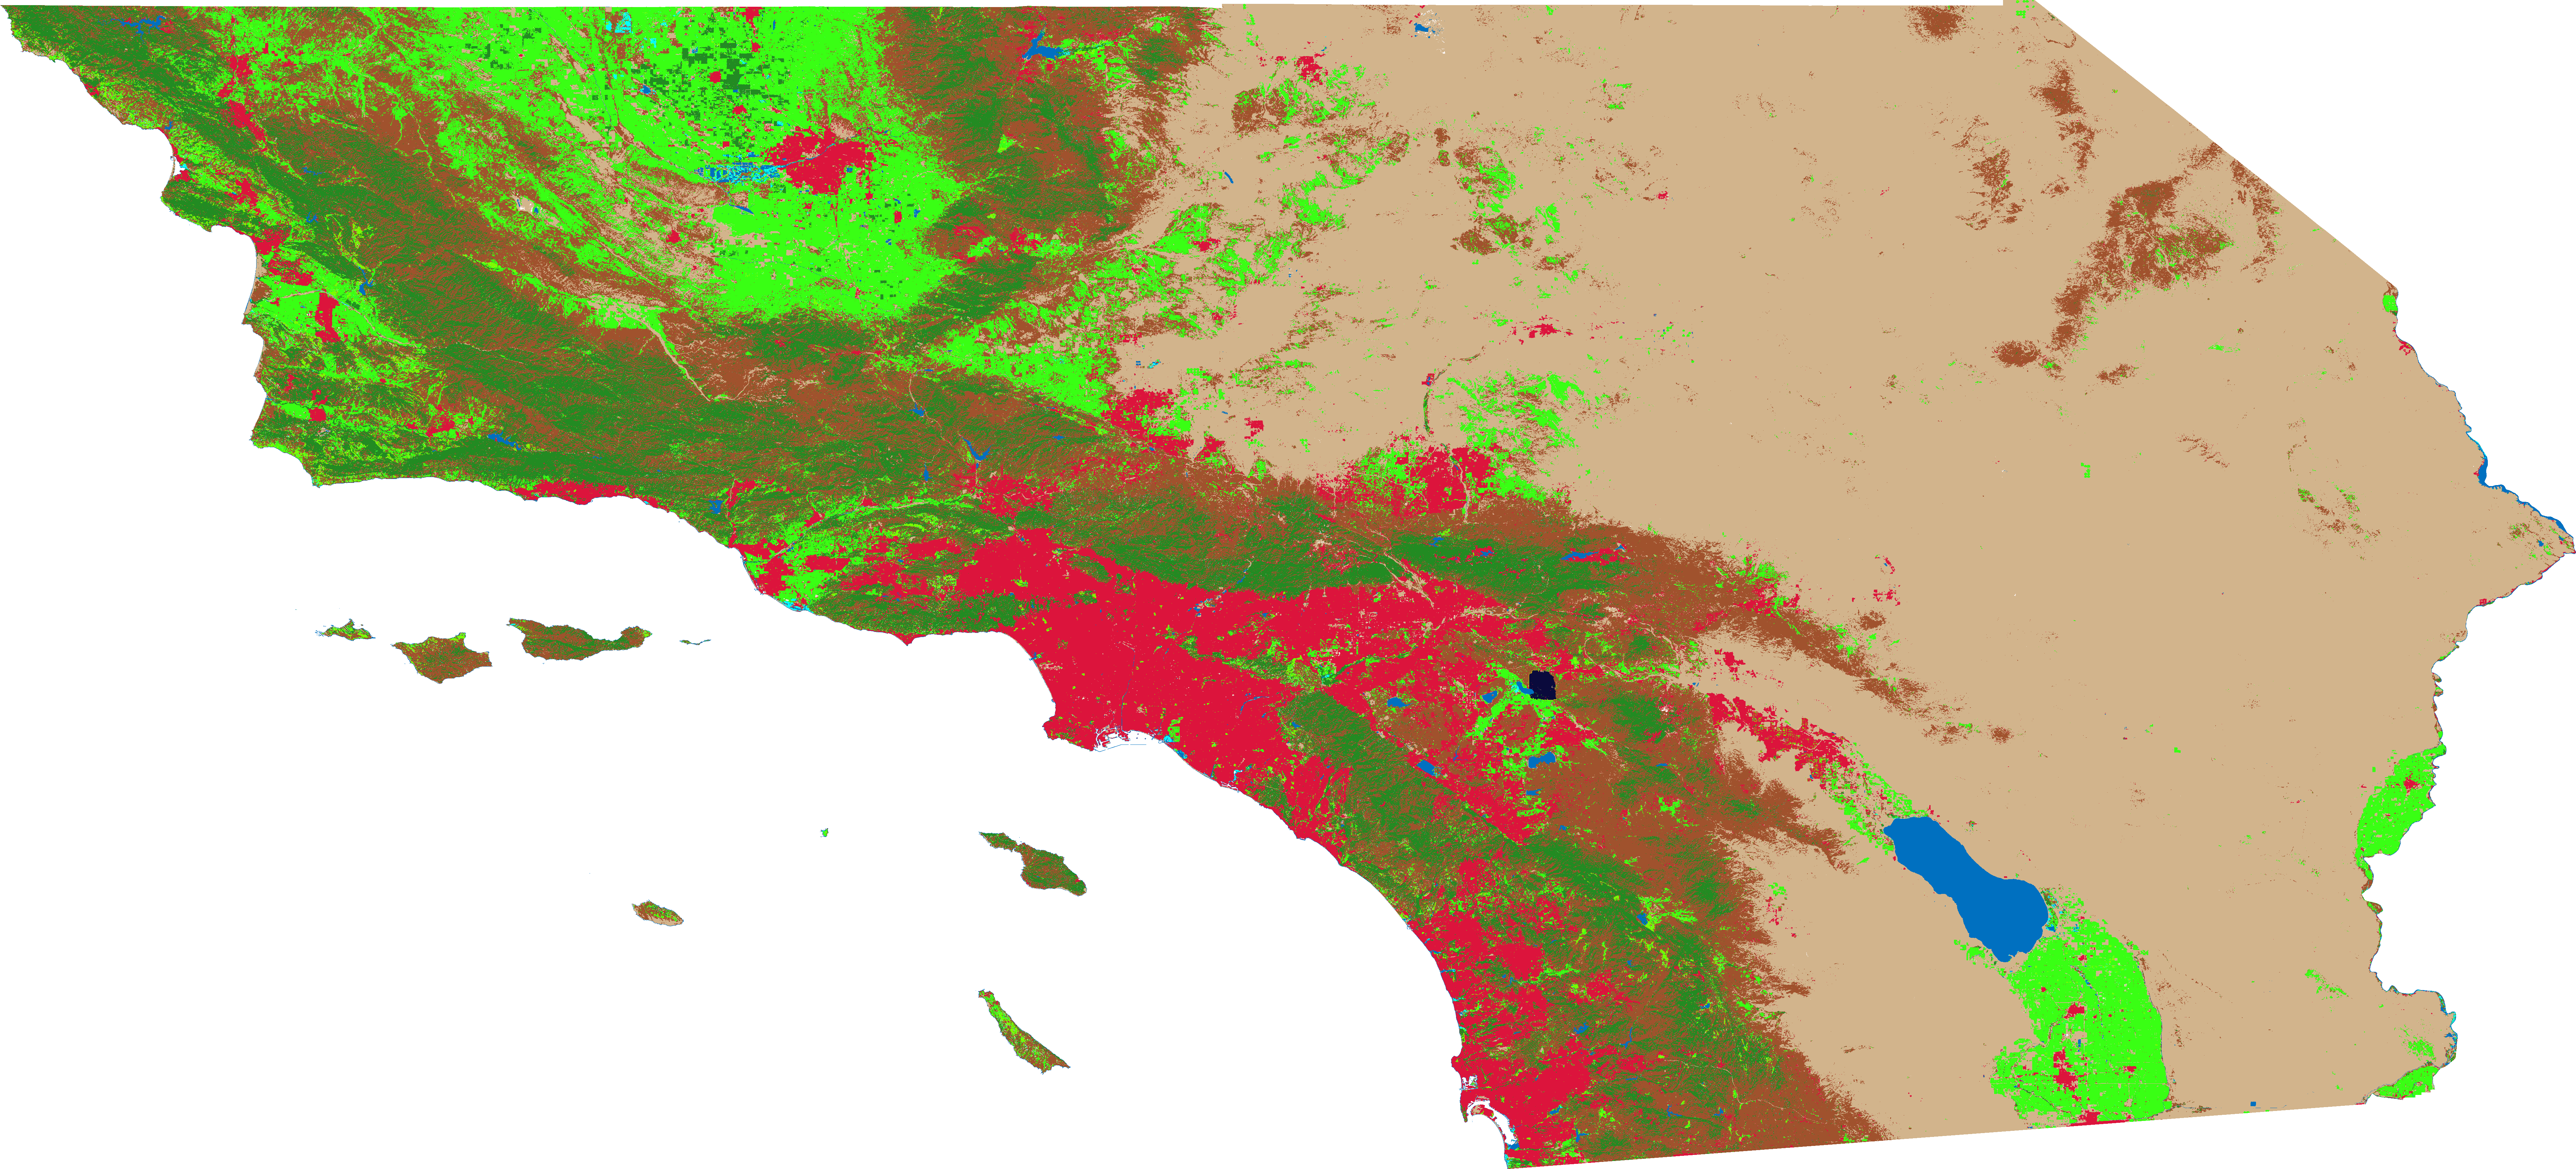

In [162]:
# === 1. Load the raster ===
with rasterio.open(os.path.join(path,"2_2_simraster47.tif")) as src:
    land_use = src.read(1)  # Read first band only
    bounds = src.bounds
    
    #land_use = np.where(land_use == -999, np.nan, land_use)

    land_use = np.ma.masked_where(np.isnan(land_use), land_use)

# === 2. Define land use classes and RGB colors ===
class_colors = {
    0: ('Water', (0, 112, 192)),
    1: ('Trees', (34, 139, 34)),
    2: ('Grass', (124, 252, 0)),
    3: ('Flooded Vegetation', (0, 255, 255)),
    4: ('Crops', (57, 255, 20)),
    5: ('Shrub and Scrub', (160, 82, 45)),
    6: ('Built', (220, 20, 60)),
    7: ('Bare', (210, 180, 140)),
    8: ('Snow and Ice', (255, 250, 250)),
    9: ('Burning', (255, 255, 0)),
    10: ('Burned', (10, 10, 60))
}

# === 3. Create an empty RGB image ===
height, width = land_use.shape
#rgb = np.zeros((height, width, 3), dtype=np.uint8)

rgba = np.zeros((height, width, 4), dtype=np.uint8)

# === 4. Map class values to RGB channels ===
#for class_val, (_, color) in class_colors.items():
    #mask = (land_use == class_val)
    #rgb[mask] = color  # This works since color is a 3-tuple (R, G, B)

for class_val, (_, color) in class_colors.items():
    mask = (land_use == class_val)
    rgba[mask, :3] = color #set RGB
    rgba[mask, 3] = 255 # fully opaque

# set alpha = 0 where land_use is Nan (transparent)
nan_mask = np.isnan(land_use)

rgba[nan_mask, 3] = 0

# === 5. Create folium map ===
# center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]

center = [35.0866, -120.01923]

m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

img_overlay = ImageOverlay(
    image=rgba,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    name='Land Use',
)

img_overlay.add_to(m)
folium.LayerControl().add_to(m)

# === 6. Custom legend ===
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed;
     bottom: 20px; left: 20px; width: 200px; height: auto;
     z-index:9999; font-size:14px;
     background-color: white;
     border:2px solid grey; border-radius:6px;
     padding: 10px;">
<h4>Land Use Legend</h4>
<ul style="list-style: none; padding: 0; margin: 0;">
""" + "".join([
    f'<li><span style="background-color: rgb{rgb}; width: 12px; height: 12px; display: inline-block; margin-right: 8px;"></span>{label}</li>'
    for label, rgb in [class_colors[i] for i in sorted(class_colors)]
]) + """
</ul>
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# === 7. Save the map ===
#m.save('land_use_map_with_legend.html')

m


In [163]:
import geopandas as gpd
import rasterio
from rasterio.features import shapes
import numpy as np
from shapely.geometry import shape, Polygon
from shapely.ops import unary_union
import json

def raster_to_polygon(tif_path, burn_value=10):
    with rasterio.open(tif_path) as src:
        raster = src.read(1)
        mask = raster == burn_value
        transform = src.transform

        # Extract polygons
        polygons = [
            shape(geom)
            for geom, val in shapes(raster, mask=mask, transform=transform)
            if val == burn_value
        ]

        return unary_union(polygons) if polygons else None

def calculate_iou(geom1: Polygon, geom2: Polygon):
    if geom1 is None or geom2 is None:
        return 0.0
    intersection = geom1.intersection(geom2).area
    union = geom1.union(geom2).area
    return intersection / union if union != 0 else 0

def save_to_geojson(geom_actual, geom_simulated, iou_score, output_path):
    features = [
        {
            "type": "Feature",
            "properties": {"type": "actual"},
            "geometry": json.loads(gpd.GeoSeries([geom_actual]).to_json())['features'][0]['geometry']
        },
        {
            "type": "Feature",
            "properties": {"type": "simulated"},
            "geometry": json.loads(gpd.GeoSeries([geom_simulated]).to_json())['features'][0]['geometry']
        },
        {
            "type": "Feature",
            "properties": {"type": "intersection", "iou": iou_score},
            "geometry": json.loads(gpd.GeoSeries([geom_actual.intersection(geom_simulated)]).to_json())['features'][0]['geometry']
        }
    ]

    geojson = {
        "type": "FeatureCollection",
        "features": features
    }

    with open(output_path, 'w') as f:
        json.dump(geojson, f, indent=2)

# === Example Usage ===
actual_geojson_path = "../data/Rabbit_fire_perimeter.geojson"
simulated_tif_path = "../experiments/dataset/2_2_simraster47.tif"
output_geojson_path = "../output/simraster_comparison_output_trial_2_2.geojson"

# Load actual perimeter
gdf_actual = gpd.read_file(actual_geojson_path)
geom_actual = unary_union(gdf_actual.geometry)

# Convert simulated raster to polygon
geom_simulated = raster_to_polygon(simulated_tif_path, burn_value=10)

# Calculate IoU
iou_score = calculate_iou(geom_actual, geom_simulated)
print(f"IoU: {iou_score:.4f}")

# Save combined output
save_to_geojson(geom_actual, geom_simulated, iou_score, output_geojson_path)
print(f"Saved combined GeoJSON to: {output_geojson_path}")


IoU: 0.5285
Saved combined GeoJSON to: ../output/simraster_comparison_output_trial_2_2.geojson


In [ ]:
IoU: 0.0516